<a href="https://www.kaggle.com/code/nickkrikota/car-price-regression?scriptVersionId=197953536" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# INTRODUCTION

## Introducing the dataset

This is a synthetic dataset generated from data on used cars. The goal of this community competition is to predict the price of a used car using regression based on features such as milage and brand. This journal will go through the process of analysing and visualizing the data to then preparing the data to be fit into a regression model.

## Importing libraries

In addition to the regular libraries of numpy and pandas I will be using seaborn and matplotlib to visualize the data. The model will consisit of an ensemble of xgboost, lightgbm and catboost. Several sklearn models will be used to process the data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print('Imported Successfully')

Imported Successfully


## Loading the data

The data is already split into train and test dataframes. After the two are loaded, we can view the shape to get an idea of the size of the datasets and the number of features.

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv', index_col='id')
print('Train columns, rows:', train.shape)
print('Test columns, rows:', test.shape)

Train columns, rows: (188533, 12)
Test columns, rows: (125690, 11)


# EDA AND PREPROCESSING

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


Here we see that the majority of the features are of the object datatype. This means that they consist of text that describes the feature rather than a number assigned to it. They will need to be converted to numeric values to be used in the regression.

## Previewing the first 10 rows

In [4]:
train.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890


Most of the data contained in each column is pretty self explanatory. The major exception is the engine column which seems to contain information about the horsepower, engine size and cylinder number of each engine. The information is in string data type and doesnt always follow the same format.

## Visualizing the data

Graphing the data can be useful to draw conclusions from it

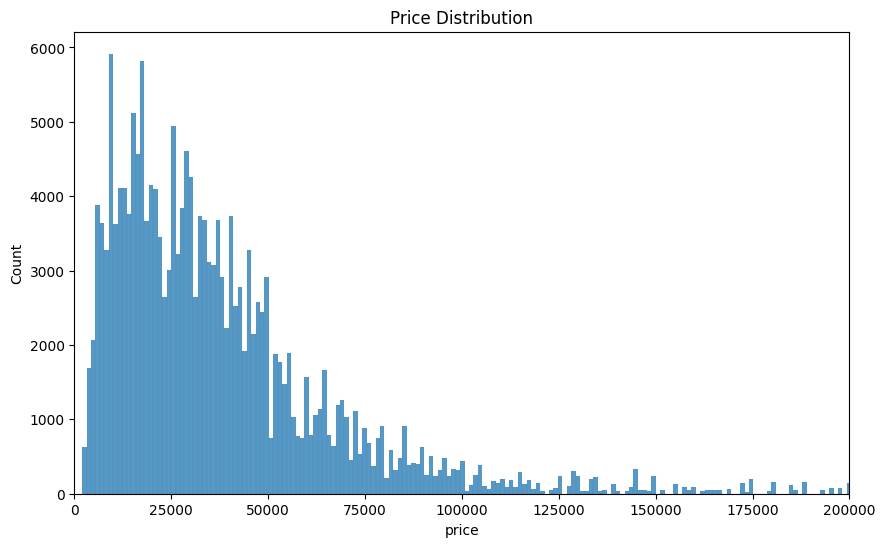

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train['price'], kde=False)
plt.xlim(0, 200000)
plt.title("Price Distribution")
plt.show()

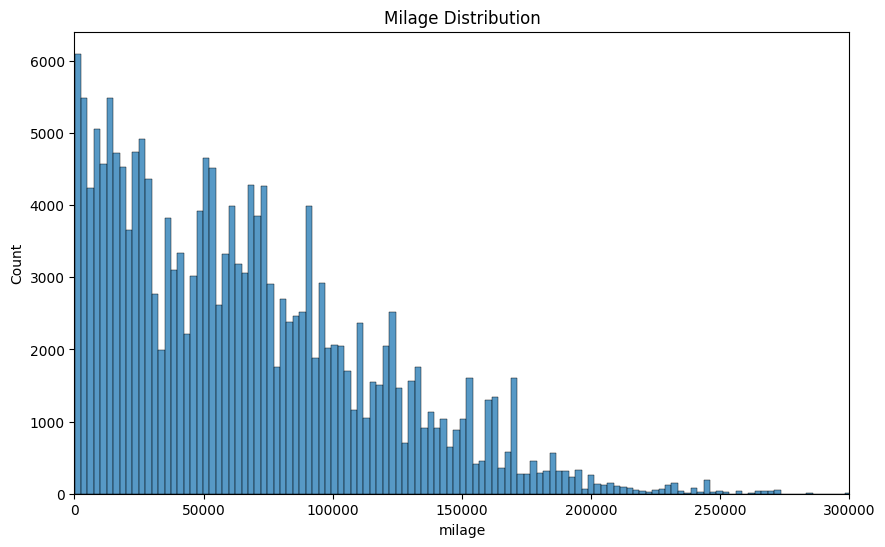

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train['milage'], kde=False)
plt.xlim(0, 300000)
plt.title("Milage Distribution")
plt.show()

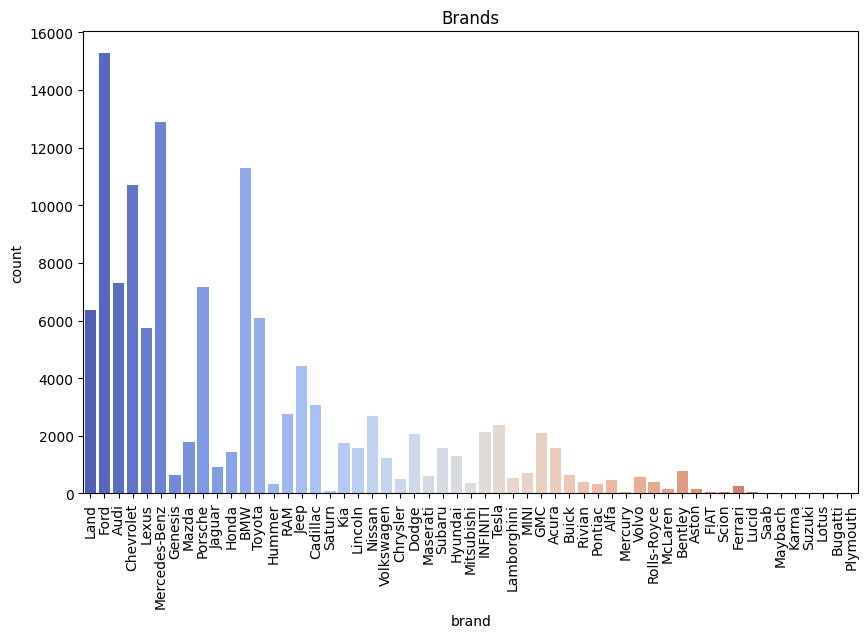

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', data=test, palette='coolwarm')
plt.title("Brands")
plt.xticks(rotation=90)
plt.show()

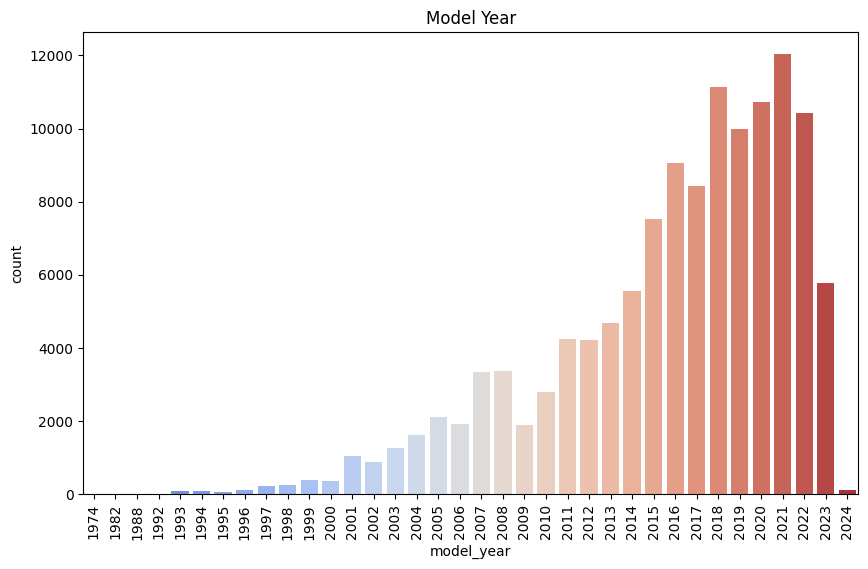

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='model_year', data=test, palette='coolwarm')
plt.title("Model Year")
plt.xticks(rotation=90)
plt.show()

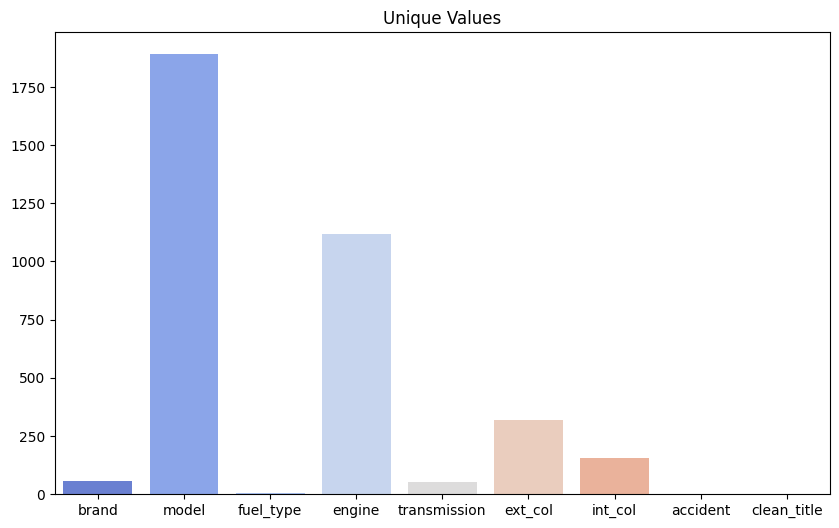

In [9]:
unique = test.select_dtypes(include='object').nunique()
plt.figure(figsize=(10, 6))
sns.barplot(x=unique.index, y=unique.values, palette='coolwarm')
plt.title("Unique Values")
plt.show()

## Exploring unique values

In [10]:
print('Number of unique values for engine:', len(train['engine'].unique()))
print('Number of unique values for fuel type:', len(train['fuel_type'].unique()))
print('Number of unique values for transmission:', len(train['transmission'].unique()))
print('Number of unique values for interior color:', len(train['int_col'].unique()))
print('Number of unique values for exterior color:', len(train['ext_col'].unique()))

Number of unique values for engine: 1117
Number of unique values for fuel type: 8
Number of unique values for transmission: 52
Number of unique values for interior color: 156
Number of unique values for exterior color: 319


The engine column has a very large number of unique values in addition to an inconsistent formatting which might not be very useful when assigning a numeric value to each one. Let's see if we can get more information out of the column.

## Creating new columns

Here we will split the column into three additional ones - horsepower, engine size and cylinders. As the data in the column doesn't always follow the same format we will need to make adjustments later.

In [11]:
train[['horsepower', 'engine_size', 'cylinders']] = train['engine'].str.split(' ', expand=True)[[0, 1, 2]]
test[['horsepower', 'engine_size', 'cylinders']] = test['engine'].str.split(' ', expand=True)[[0, 1, 2]]
train.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders
id,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0HP,1.6L,4
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0HP,3.9L,8
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0HP,5.3L,8
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0HP,5.0L,8
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0HP,2.0L,4
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,252.0HP,2.0L,4
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,333.0HP,3.0L,V6
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,355.0HP,5.3L,8
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,2.7L,V6,24V


## Correcting the new columns

We can see that there are numerous errors such as values corresponding to the engine size in horsepower column. To avoid that we will make sure that only data with 'HP' goes into the horsepower column otherwise it is changed to N/A. We can fill that with a median  value later. Similary, only data with an 'L' (engine size measured in liters) will go in the engine size columns. After that the letters are removed so the data is of the float data type. There will still be some exceptions but this will do a lot to keep the data clean and consistent.

In [12]:
train['horsepower'] = np.where(train['horsepower'].str.contains('HP'), train['horsepower'], np.nan)
train['horsepower'] = train['horsepower'].str.extract('(\d+\.?\d*)').astype(float)
test['horsepower'] = np.where(test['horsepower'].str.contains('HP'), test['horsepower'], np.nan)
test['horsepower'] = test['horsepower'].str.extract('(\d+\.?\d*)').astype(float)

train['engine_size'] = np.where(train['engine_size'].str.contains('L'), train['engine_size'], np.nan)
train['engine_size'] = train['engine_size'].str.extract('(\d+\.?\d*)').astype(float)
test['engine_size'] = np.where(test['engine_size'].str.contains('L'), test['engine_size'], np.nan)
test['engine_size'] = test['engine_size'].str.extract('(\d+\.?\d*)').astype(float)

train['cylinders'] = train['cylinders'].str.extract('(\d+)').astype(float)
test['cylinders'] = test['cylinders'].str.extract('(\d+)').astype(float)

train.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders
id,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,252.0,2.0,4.0
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,333.0,3.0,6.0
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,355.0,5.3,8.0
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,NaN,NaN,24.0


This looks much better. Now we have consistent numerical data in these new columns.

## Viewing the number of null values

In [13]:
print(train.isnull().sum())
print(test.isnull().sum())

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
horsepower      33259
engine_size     37886
cylinders       31616
dtype: int64
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
horsepower      22181
engine_size     25185
cylinders       21044
dtype: int64


In addition to the null values in fuel_type, accident and clean_title, creating and processing the new columns created a large number of null values.

## Filling the nulls with median values

Before imputing and assigning numerical values to text data, we can fill the null values in the new columns as it would take quite a long time to do with an imputer.

In [14]:
new_columns = ['horsepower', 'engine_size', 'cylinders']
train[new_columns] = train[new_columns].fillna(train[new_columns].median())
test[new_columns] = test[new_columns].fillna(test[new_columns].median())
train.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders
id,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,252.0,2.0,4.0
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,333.0,3.0,6.0
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,355.0,5.3,8.0
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,329.0,3.5,24.0


## Imputing missing values and encoding object type data 

Now we can fill the remainder of missing values using knn impute. After that is done, we will need to encode the object data types (ones that include text) into numeric values to be used by the regression models.

In [15]:
def knn_impute(df, n_neighbors=5):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

train = knn_impute(train, n_neighbors=25)
test = knn_impute(test, n_neighbors=25)

cat_cols_train = train.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train[cat_cols_train] = ordinal_encoder.fit_transform(train[cat_cols_train].astype(str))
test[cat_cols_train] = ordinal_encoder.transform(test[cat_cols_train].astype(str))

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   brand         188533 non-null  float64
 1   model         188533 non-null  float64
 2   model_year    188533 non-null  float64
 3   milage        188533 non-null  float64
 4   fuel_type     188533 non-null  float64
 5   engine        188533 non-null  float64
 6   transmission  188533 non-null  float64
 7   ext_col       188533 non-null  float64
 8   int_col       188533 non-null  float64
 9   accident      188533 non-null  float64
 10  clean_title   188533 non-null  float64
 11  price         188533 non-null  float64
 12  horsepower    188533 non-null  float64
 13  engine_size   188533 non-null  float64
 14  cylinders     188533 non-null  float64
dtypes: float64(15)
memory usage: 21.6 MB


All the data is now the same type.

In [16]:
train.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
engine_size     0
cylinders       0
dtype: int64

As we can see there are now no null values anywhere in the dataset.

# FEATURE ENGINEERING

## Correlation matrix

Let's take a look at the correlation matrix which will tell us how much each feature correlates with each other. A high positive correlation means that as one feature increases so does the other and vice versa.

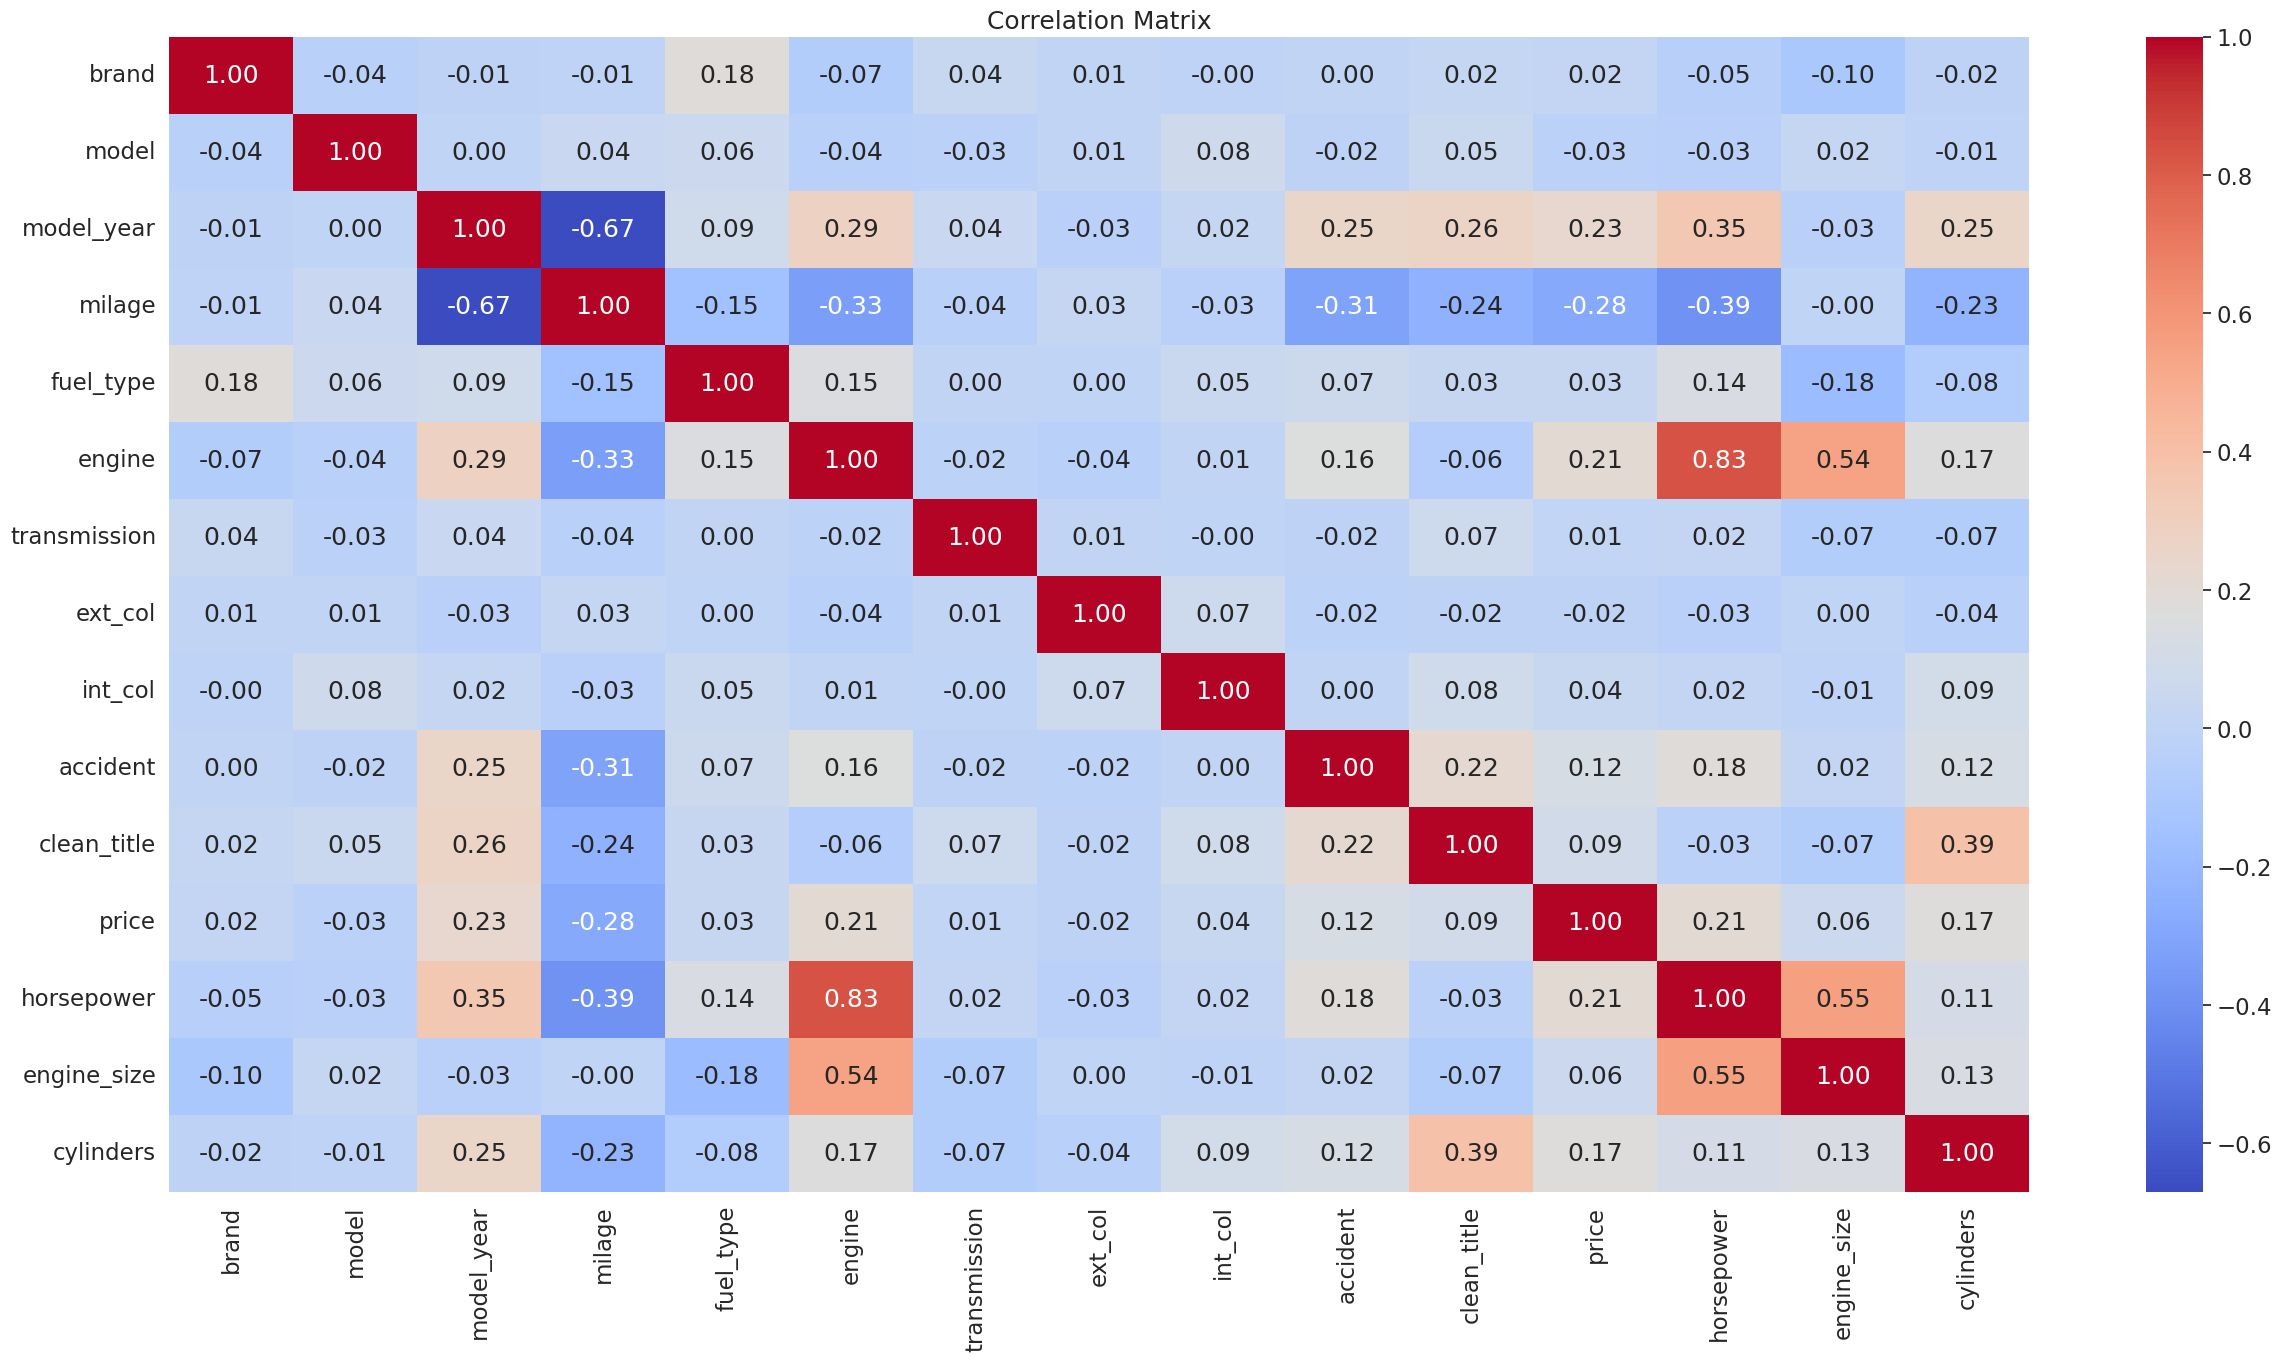

In [17]:
sns.set(font_scale=1.5)
plt.figure(figsize=(30, 15))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Correlation with the target value

Seeing the correlation coefficient with the target values of price will give us a better idea of which features increase and decrease the price of a used car and how much. 

In [18]:
print(train.corr().price.sort_values(ascending=False))

price           1.000000
model_year      0.231795
engine          0.208285
horsepower      0.207837
cylinders       0.174346
accident        0.123034
clean_title     0.089433
engine_size     0.058260
int_col         0.035174
fuel_type       0.034321
brand           0.017657
transmission    0.014560
ext_col        -0.017342
model          -0.029865
milage         -0.283067
Name: price, dtype: float64


Features such as model year (the higher the year the newer the car) have a large positive effect on the price. While features such as milage have a large negative effect. We can also see that features gained from the engine column give us quite a lot of information with respect to the car's price.

## Creating features

An example of a feature that can be added is the relationship between milage and the car's age to give us more information about the price.

In [19]:
train['milage/age'] = train['milage'] / (max(train['model_year']) - train['model_year'] + 1)
test['milage/age'] = test['milage'] / (max(train['model_year']) - test['model_year'] + 1)

train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'horsepower', 'engine_size', 'cylinders', 'milage/age'],
      dtype='object')

## Dropping features

Features such as interior and exterior color have low correlation with the price in addition to a large amount of unique values as seen previously which won't tell us much about the car's value. They can be dropped.

In [20]:
train = train.drop(columns=(['ext_col', 'int_col']))
test = test.drop(columns=(['ext_col', 'int_col']))

train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'accident', 'clean_title', 'price', 'horsepower',
       'engine_size', 'cylinders', 'milage/age'],
      dtype='object')

## Data skewness

Let's see if any of the data is skewed.

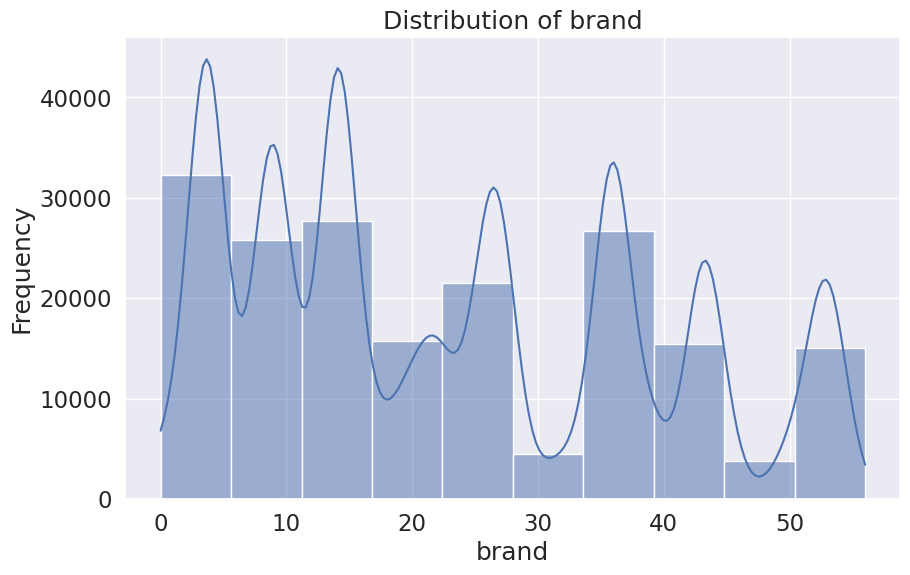

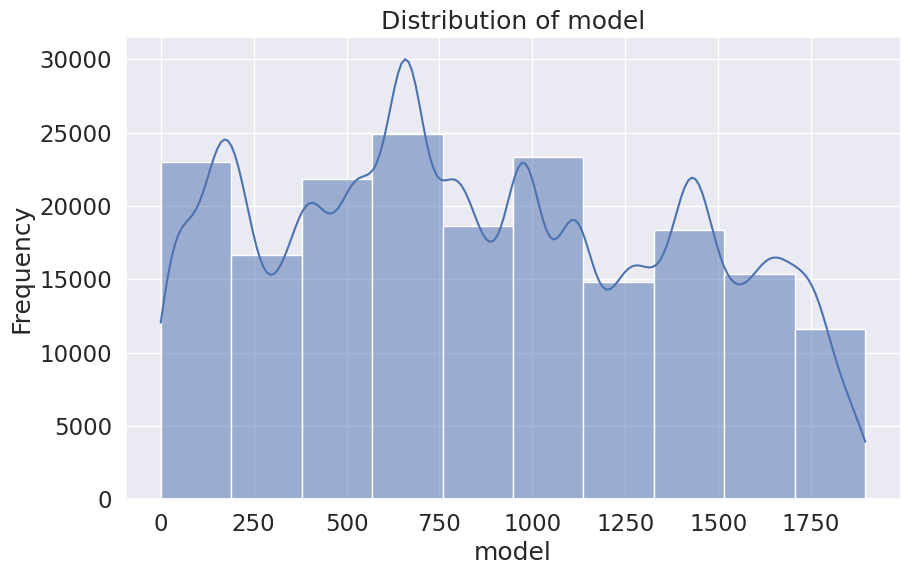

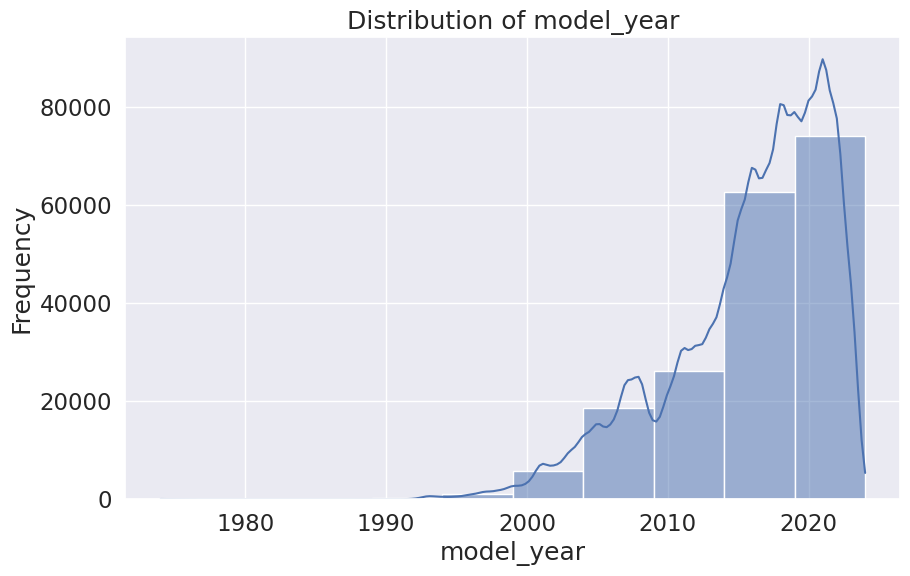

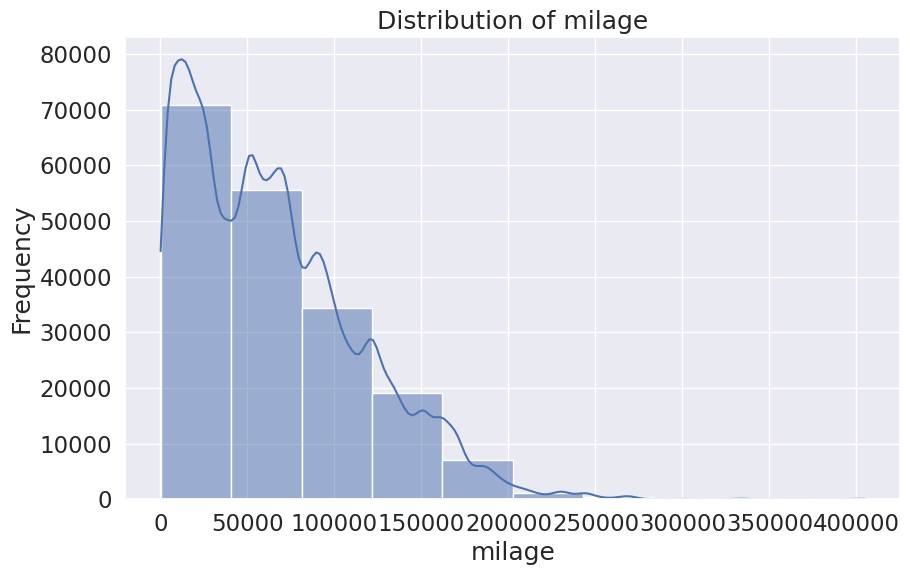

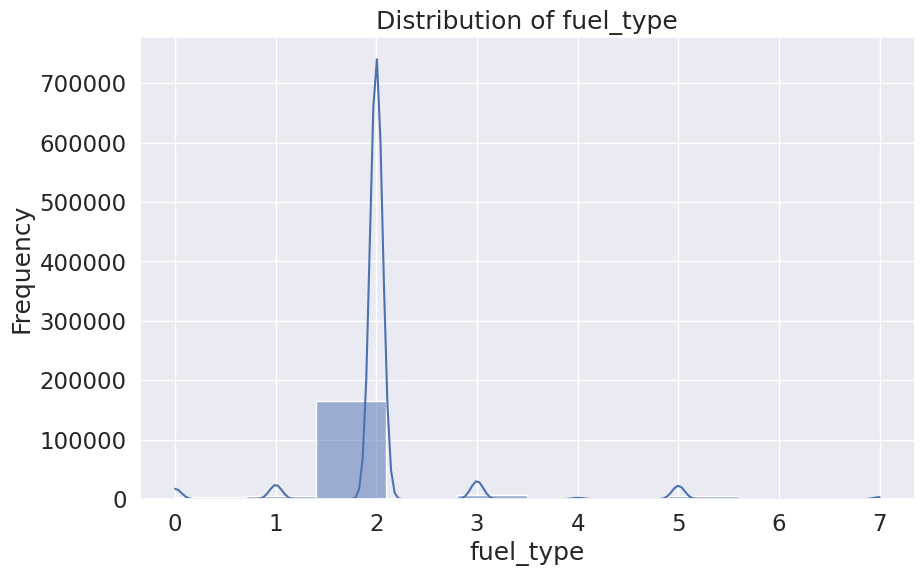

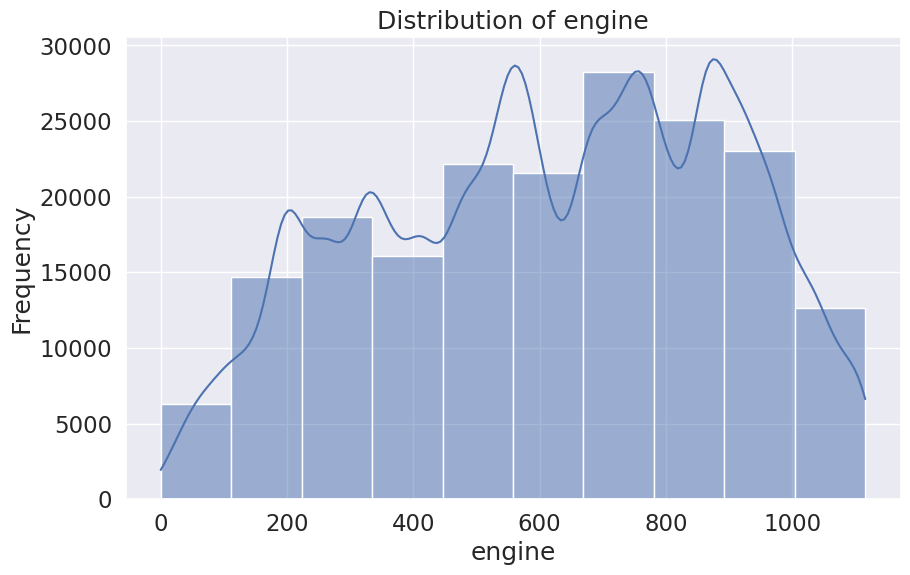

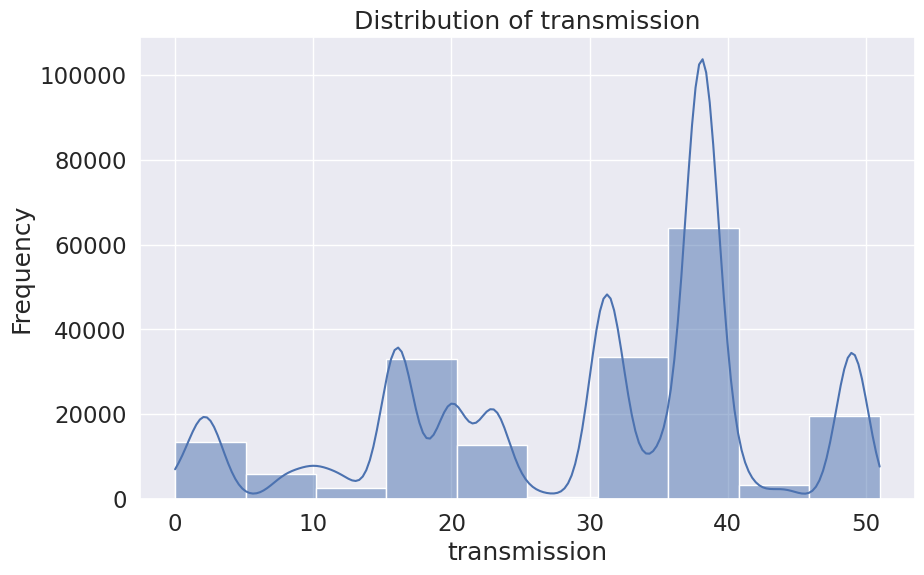

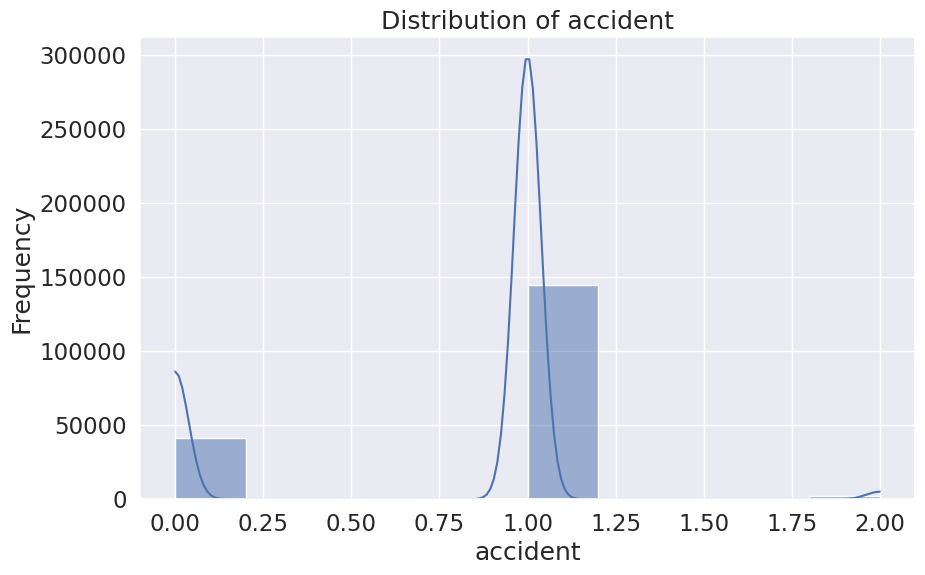

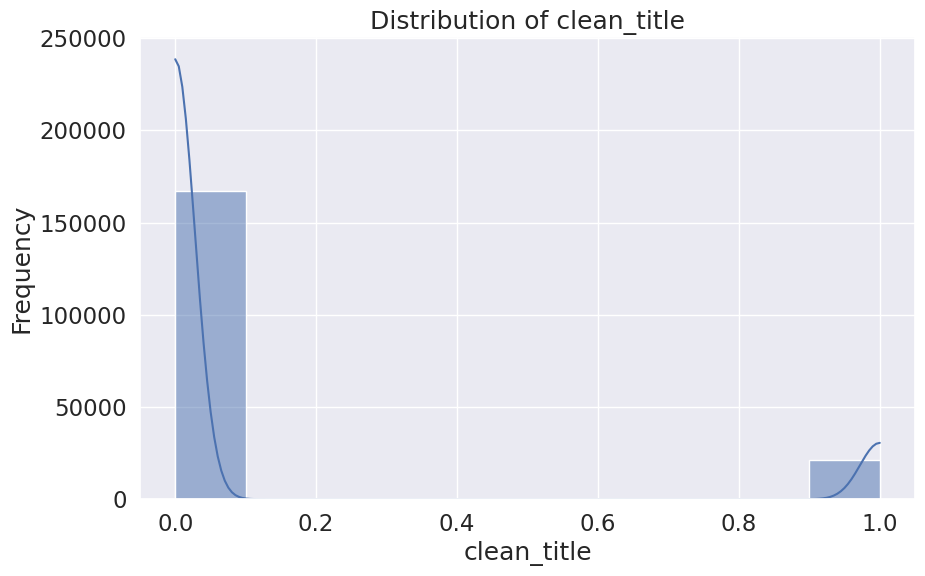

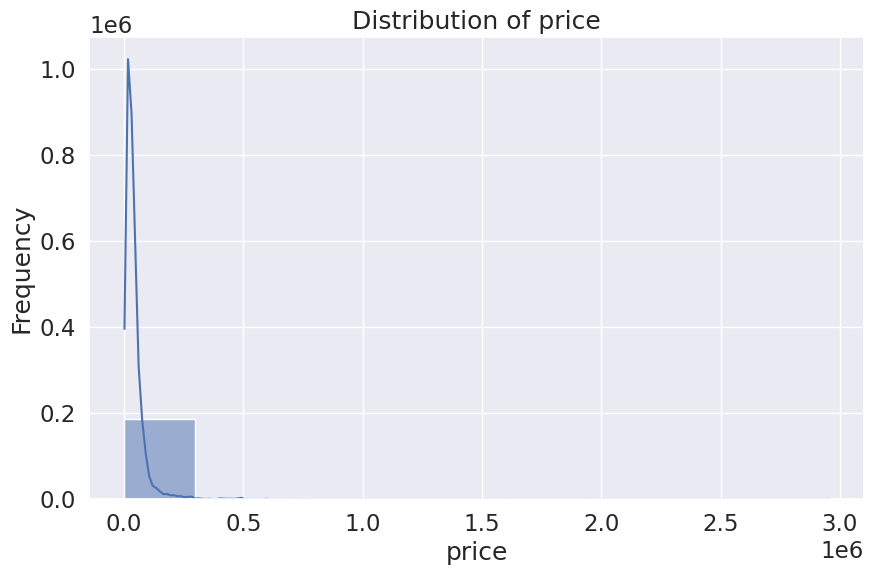

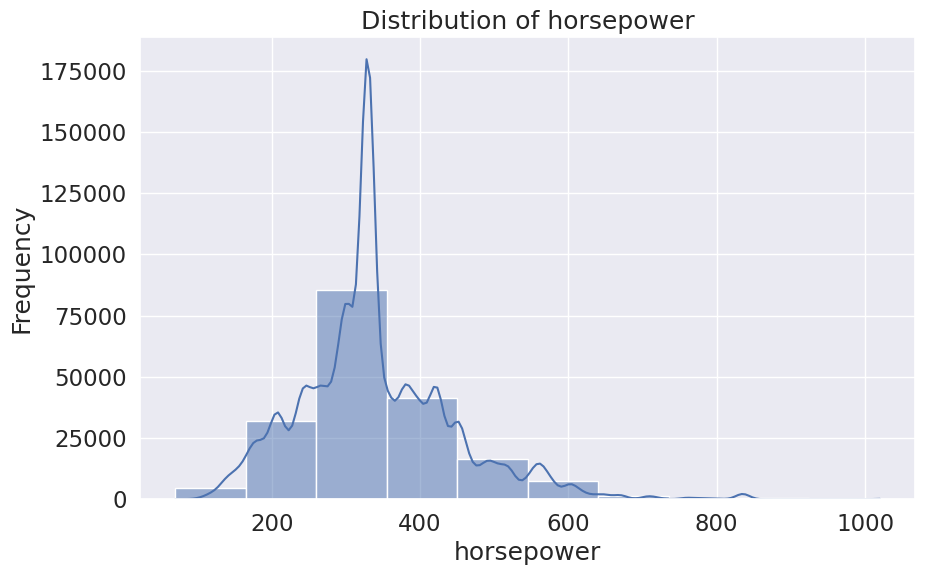

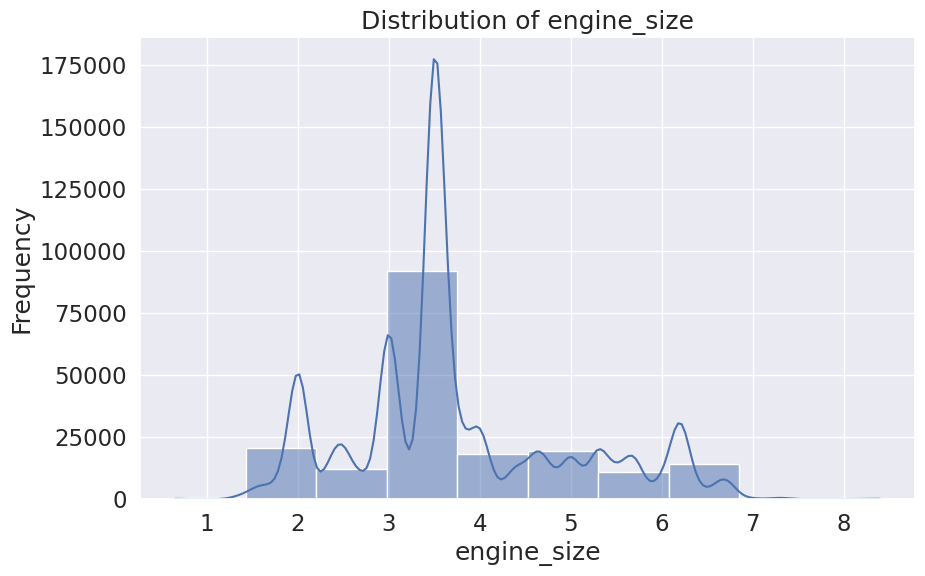

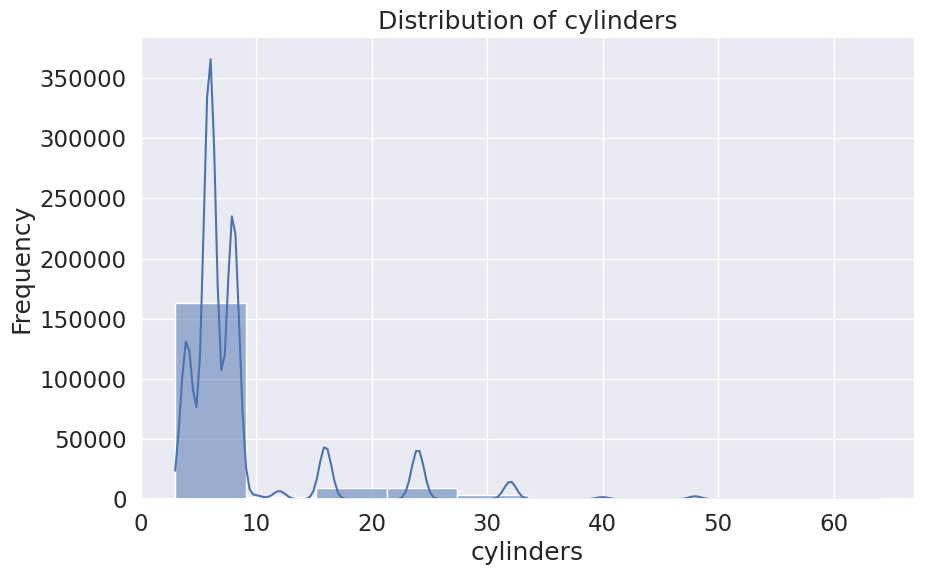

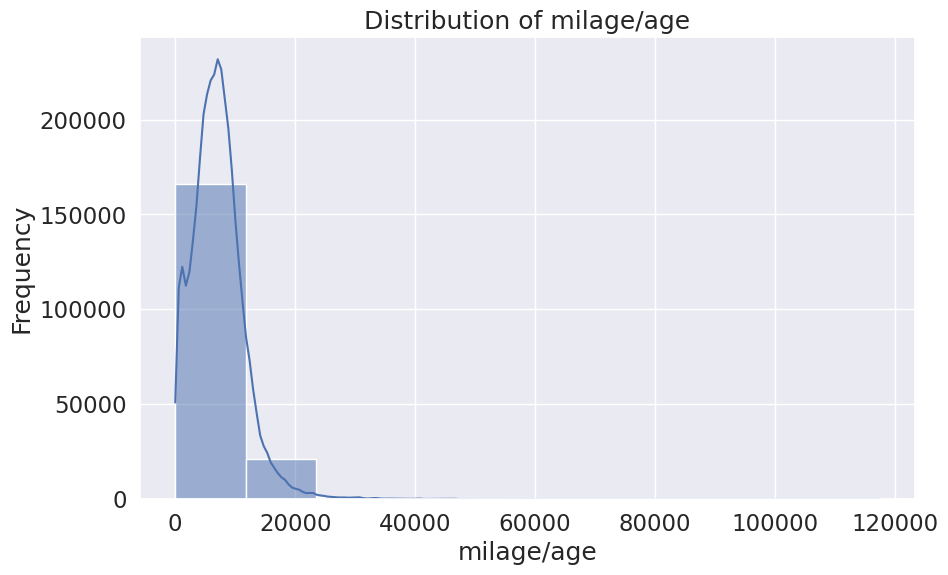

In [21]:
for column in train.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(train[column], kde=True, bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.show()

Milage and milage/age are skewed to the right. We can fix that by taking the square root of the value.

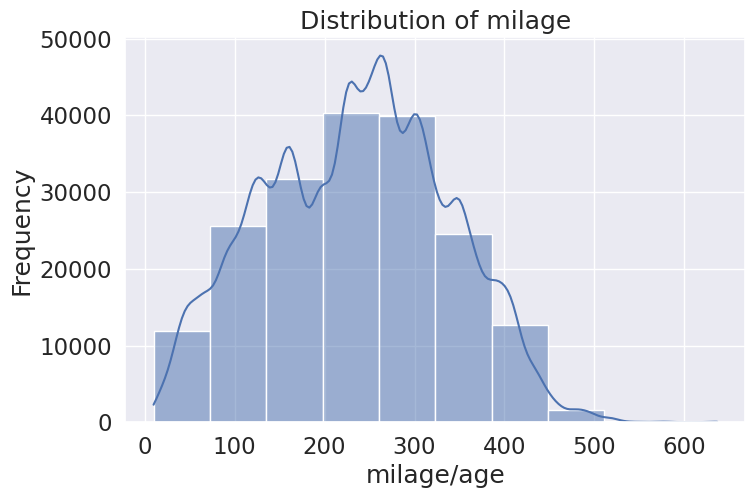

In [22]:
train['milage'] = np.sqrt(train['milage'])
test['milage'] = np.sqrt(test['milage'])

plt.figure(figsize=(8, 5))
sns.histplot(train['milage'], kde=True, bins=10)
plt.title(f'Distribution of milage')
plt.xlabel(f'{column}')
plt.ylabel('Frequency')
plt.show()

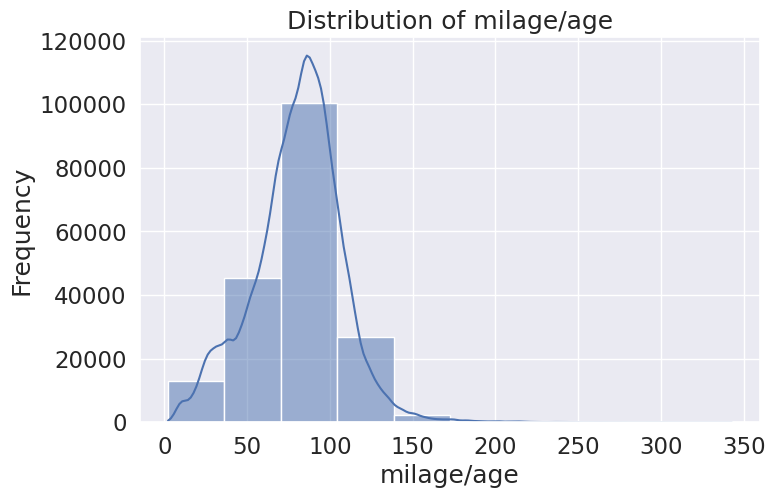

In [23]:
train['milage/age'] = np.sqrt(train['milage/age'])
test['milage/age'] = np.sqrt(test['milage/age'])

plt.figure(figsize=(8, 5))
sns.histplot(train['milage/age'], kde=True, bins=10)
plt.title(f'Distribution of {column}')
plt.xlabel(f'{column}')
plt.ylabel('Frequency')
plt.show()

## Target value and scaling the data

After unskewing some of the variables with can go ahead and scale the data to make it more managable by the model.

In [24]:
y = train['price'] 
X = train.drop(['price'],axis=1)

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X)
scaled_test_data = scaler.transform(test)

y.shape, X.shape

((188533,), (188533, 13))

# REGRESSION

## Model ensemble

Now we can use a combination of Catboost, LightGBM and XGBoost to predict the price of used cars.

Note that here we will be using default parameters. You can get better results by optimizing parameters for each model but this will take much longer to compute. See link to Satya's notebook in the conclusion for an example of optimized parameters.

In [25]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cb_predictions = np.zeros(len(scaled_train_data))
cb_true_labels = np.zeros(len(scaled_train_data))
cb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cb_model = CatBoostRegressor(verbose = 0)

    cb_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)]          
                  )
    
    cb_fold_preds = cb_model.predict(X_val)
    cb_fold_test_preds = cb_model.predict(scaled_test_data)
    cb_predictions[val_idx] = cb_fold_preds
    cb_true_labels[val_idx] = y_val
    cb_test_predictions += cb_fold_test_preds / n_splits 
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, cb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_cb = np.sqrt(mean_squared_error(cb_true_labels, cb_predictions))
print(f"Overall RMSE (CatBoostRegressor): {overall_rmse_cb:.4f}")

Training fold 1/10...
Fold 1 RMSE: 69265.7883
Training fold 2/10...
Fold 2 RMSE: 66329.8139
Training fold 3/10...
Fold 3 RMSE: 62374.3838
Training fold 4/10...
Fold 4 RMSE: 74518.6039
Training fold 5/10...
Fold 5 RMSE: 85213.9402
Training fold 6/10...
Fold 6 RMSE: 60983.5334
Training fold 7/10...
Fold 7 RMSE: 74407.6448
Training fold 8/10...
Fold 8 RMSE: 78500.2301
Training fold 9/10...
Fold 9 RMSE: 71171.8866
Training fold 10/10...
Fold 10 RMSE: 81023.1559
Overall RMSE (CatBoostRegressor): 72766.8958


In [26]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(verbose = -1)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',          
                  )

    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits 
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/10...
Fold 1 RMSE: 69249.8008
Training fold 2/10...
Fold 2 RMSE: 66840.0175
Training fold 3/10...
Fold 3 RMSE: 62811.9046
Training fold 4/10...
Fold 4 RMSE: 74625.0738
Training fold 5/10...
Fold 5 RMSE: 85423.6876
Training fold 6/10...
Fold 6 RMSE: 61390.5791
Training fold 7/10...
Fold 7 RMSE: 74795.3261
Training fold 8/10...
Fold 8 RMSE: 78710.9601
Training fold 9/10...
Fold 9 RMSE: 71283.8443
Training fold 10/10...
Fold 10 RMSE: 81274.6169
Overall RMSE (LGBMRegressor): 73020.4954


In [27]:
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='rmse',
                  early_stopping_rounds=10,
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits  

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")

Training fold 1/10...
Fold 1 RMSE: 69804.6772
Training fold 2/10...
Fold 2 RMSE: 66589.5959
Training fold 3/10...
Fold 3 RMSE: 62683.7799
Training fold 4/10...
Fold 4 RMSE: 75078.8017
Training fold 5/10...
Fold 5 RMSE: 85381.6051
Training fold 6/10...
Fold 6 RMSE: 61225.9005
Training fold 7/10...
Fold 7 RMSE: 74851.4529
Training fold 8/10...
Fold 8 RMSE: 78844.0141
Training fold 9/10...
Fold 9 RMSE: 71431.0378
Training fold 10/10...
Fold 10 RMSE: 81365.7715
Overall RMSE (XGBRegressor): 73111.7852


## Assigning weights and making the submission

Now we can assign weights to our model and submit the data. Adjusting the weight of each model will give a different result.

In [28]:
submission = pd.read_csv("/kaggle/input/playground-series-s4e9/sample_submission.csv")
submission['price'] = cb_test_predictions*0.45 + lgbm_test_predictions*0.30 + xgb_test_predictions*0.25

submission.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,price
0,188533,17955.112158
1,188534,78310.723414
2,188535,54611.280498
3,188536,23972.604655
4,188537,30796.969824
...,...,...
125685,314218,26807.698131
125686,314219,46832.321965
125687,314220,24451.274293
125688,314221,17160.332658


# CONCLUSION

I hope that this notebook made the whole process much simpler to understand. Thanks to Satya and Jamil whose notebooks were helpful in the creation of this one as well as furthering my own study of data science.

https://www.kaggle.com/code/satyaprakashshukl/used-car-price-prediction

https://www.kaggle.com/code/mjamilmoughal/eda-and-feature-engineering-of-used-car-prices

Thank you for reading. Any feedback is welcome.